# Treinando a rede com 64 features

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
import optuna

In [2]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 14042003

NUM_EPOCAS = 50

In [3]:
df = pickle.load(open('df_novo', 'rb'))
dados = df.drop(['Material compositions'], axis=1)
target =  ['Trg']
Features = list(dados.columns)[1:]

### DataModule

In [4]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        tamanho_lote=64,
        num_trabalhadores=4,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

    def setup(self, stage):
       
        features = list(dados.columns)[1:]
        target = ["Trg"]

        df = dados

        df = df.reindex(features + target, axis=1)

        indices = df.index
        indices_treino_val, indices_teste = train_test_split(
            indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
        )

        df_treino_val = df.loc[indices_treino_val]
        df_teste = df.loc[indices_teste]

        indices = df_treino_val.index
        indices_treino, indices_val = train_test_split(
            indices,
            test_size=TAMANHO_TESTE,
            random_state=SEMENTE_ALEATORIA,
        )

        df_treino = df.loc[indices_treino]
        df_val = df.loc[indices_val]

        X_treino = df_treino.reindex(features, axis=1).values
        y_treino = df_treino.reindex(target, axis=1).values

        self.x_scaler = MaxAbsScaler()
        self.x_scaler.fit(X_treino)

        self.y_scaler = MaxAbsScaler()
        self.y_scaler.fit(y_treino)

        if stage == "fit":
            X_val = df_val.reindex(features, axis=1).values
            y_val = df_val.reindex(target, axis=1).values

            X_treino = self.x_scaler.transform(X_treino)
            y_treino = self.y_scaler.transform(y_treino)

            X_val = self.x_scaler.transform(X_val)
            y_val = self.y_scaler.transform(y_val)

            self.X_treino = torch.tensor(X_treino, dtype=torch.float32)
            self.y_treino = torch.tensor(y_treino, dtype=torch.float32)

            self.X_val = torch.tensor(X_val, dtype=torch.float32)
            self.y_val = torch.tensor(y_val, dtype=torch.float32)

        if stage == "test":
            X_teste = df_teste.reindex(features, axis=1).values
            y_teste = df_teste.reindex(target, axis=1).values

            X_teste = self.x_scaler.transform(X_teste)
            y_teste = self.y_scaler.transform(y_teste)

            self.X_teste = torch.tensor(X_teste, dtype=torch.float32)
            self.y_teste = torch.tensor(y_teste, dtype=torch.float32)

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader
        TensorDataset(self.X_teste, self.y_teste),
        batch_size=self.tamanho_lote,
        num_workers=self.num_trabalhadores,
    

### MLP

In [5]:
class MLP(pl.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, neuronios_c3, neuronios_c4, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(neuronios_c2, neuronios_c3),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(neuronios_c3, neuronios_c4),
            nn.ReLU(),
            nn.Dropout(0.05),
            nn.Linear(neuronios_c4, num_targets),
        )

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr = 0.01)
        return optimizer

### Treinador e instância DataModule

In [6]:
treinador = pl.Trainer(max_epochs=NUM_EPOCAS)
dm = DataModule()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### MLP com melhor trial

In [7]:
num_dados_de_entrada = 64
num_dados_de_saida = 1
neuronios_c1 = 20
neuronios_c2 = 20
neuronios_c3 = 20
neuronios_c4 = 20

minha_mlp = MLP(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, neuronios_c3, neuronios_c4, num_dados_de_saida
)

In [8]:
treinador.fit(minha_mlp, dm)


  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 2.6 K 
---------------------------------------
2.6 K     Trainable params
0         Non-trainable params
2.6 K     Total params
0.010     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\venv\ilumpy\lib\site-packages\pytorch_lightning\trainer\trainer.py:1558: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

c:\venv\ilumpy\lib\site-packages\pytorch_lightning\callbacks\progress\base.py:249: UserWarning: The progress bar already tracks a metric with the name(s) 'loss' and `self.log('loss', ..., prog_bar=True)` will overwrite this value.  If this is undesired, change the name or override `get_metrics()` in the progress bar callback.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


### Avaliando o modelo

In [9]:
minha_mlp.eval()
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)
    
    RMSE = mean_squared_error(y_true, y_pred, squared = False)

    print(RMSE)

0.04083505800782696


### Curva de Aprendizado 

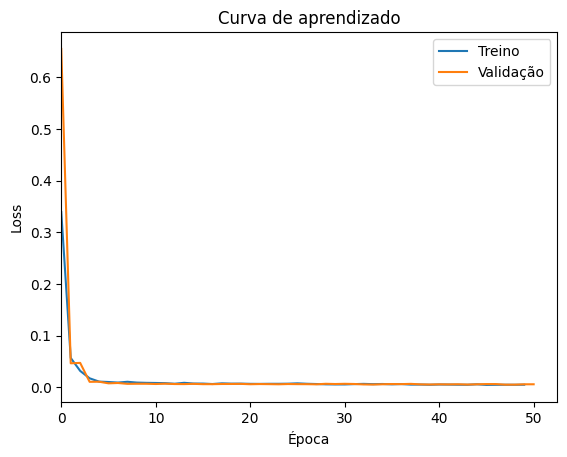

In [10]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss");

In [11]:
import csv
# Arrays de exemplo
array1 = y_true
array2 = y_pred

# Nome do arquivo CSV
filename = 'output.csv'

# Criar e escrever no arquivo CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Escrever cabeçalhos (opcional)
    writer.writerow(['Real', 'Previsto'])
    
    # Escrever os dados
    for a1, a2 in zip(array1, array2):
        writer.writerow([a1, a2])

mostra = pd.read_csv('output.csv')
mostra

,Real,Previsto
0,[0.563],[0.57764219]
1,[0.60899998],[0.62659167]
2,[0.60899998],[0.59322991]
3,[0.56999998],[0.53957336]
4,[0.606],[0.56271295]
5,[0.50300001],[0.53951632]
6,[0.53899999],[0.57452165]
7,[0.58500001],[0.54799214]
8,[0.62699999],[0.58212564]
9,[0.561],[0.55605358]


## Análise SHAP

Para uma análise geral das nossas features a partir da previsão, podemos implementar o uso da análise SHAP, que é um tipo de análise bastante utilizado para compreender a importância e peso de cada feature em relação ao nosso treino. Com isso, plotamos o gráfico abaixo:

Permutation explainer: 424it [00:33, 12.81it/s]                                                                        
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


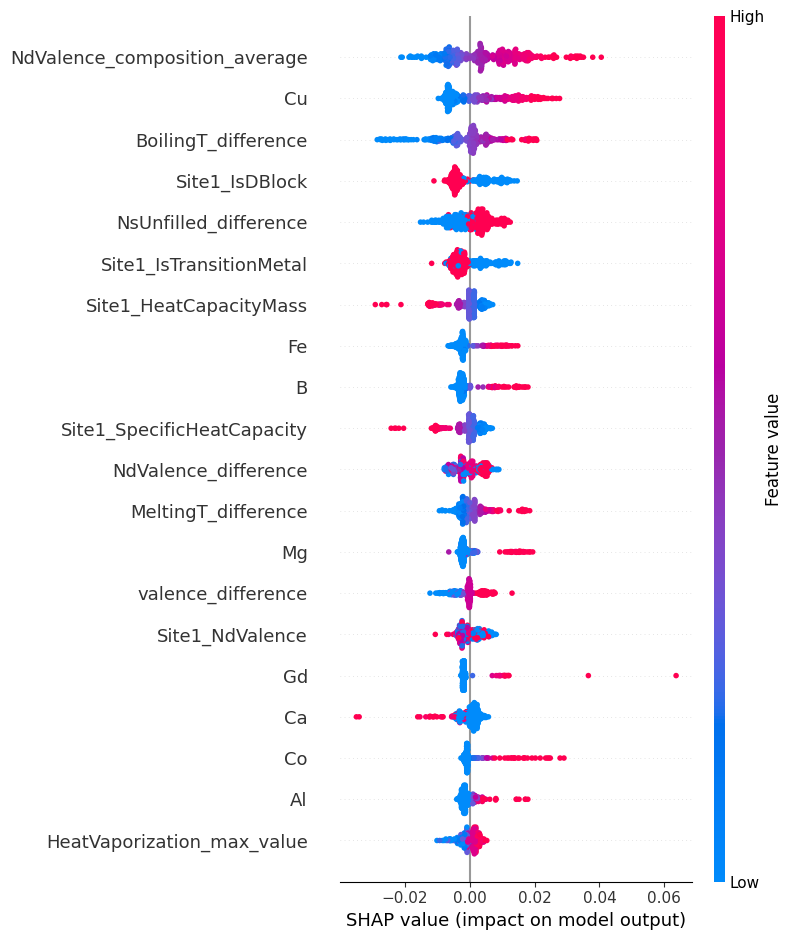

In [14]:
import torch
import shap
import numpy as np
 
shap.initjs()
 
data = dm.X_treino
data_numpy = data.detach().cpu().numpy()
features = dados.drop(['Trg'], axis=1)
feature_names = features.columns.tolist()
 
# Criar um wrapper para o modelo do PyTorch Lightning
class WrappedModel:
    def __init__(self, pytorch_lightning_model):
        self.model = pytorch_lightning_model
 
    def __call__(self, data):
        data_tensor = torch.tensor(data, dtype=torch.float32)
        with torch.no_grad():
            return self.model(data_tensor).cpu().numpy()
 
wrapped_model = WrappedModel(minha_mlp)
 
# Usar SHAP com o modelo wrapper
explainer = shap.Explainer(wrapped_model, data_numpy[:50])
shap_values = explainer(data_numpy[50:])
 
# Visualizar os resultados com nomes das features
shap.summary_plot(shap_values, data_numpy[50:], feature_names=feature_names)

A partir da plotagem acima, é possível visualizar uma distribuição de pontos diferente para cada feature. De modo geral, cada dado está sendo representado por um ponto, de maneira que, quanto mais azul (perto do azul claro), menor a importância daquela feature para a previsão, e quanto mais vermelho, maior a importância da feature para a previsão do dado. A dispersão para a esquerda e direita nos diz o quanto essa variação pode implicar no peso da feature. Como exemplo, vejamos a feature 'NdValence_composition_average'. Quando os dados são negativos, os pontos estão predominantemente em azul, significando que a feature não possui tanto peso para a previsão, e, quanto mais à direita (dados positivos), a feature possui uma importância maior. Para esse data_set, podemos ver que as features 'NdValence_composition_average', 'Cu' e 'BoillingT_diference' são as que mais impactam nessa previsão.

